# Проект: классификация

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [4]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')

In [5]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


### Задание 2

In [6]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
df['job'].value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

### Задание 3

In [7]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
df['balance'] = df['balance'].apply(lambda x: float(str(x).replace(' $', '').replace(',00', '').replace(' ', '')))

In [8]:
round(df['balance'].mean(), 3)

1529.129

### Задание 4

In [9]:
df['balance'] = df['balance'].apply(lambda x: df['balance'].median() if str(x)=='nan' else x)

In [10]:
round(df['balance'].mean(), 3)

1526.936

### Задание 5

In [11]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
df['job']= df['job'].apply(lambda x: df['job'].mode().iloc[0] if x == 'unknown' else x)
df['education']= df['education'].apply(lambda x: df['education'].mode().iloc[0] if x == 'unknown' else x)

In [12]:
mask1 = df['job'] == df['job'].mode().iloc[0]
mask2 = df['education'] == df['education'].mode().iloc[0]

df_filtered=df[mask1 & mask2]
round(df_filtered['balance'].mean(), 3)

1598.883

### Задание 6

In [13]:
df_cleaned = df.copy()

In [14]:
x = df_cleaned['balance']
quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
iqr = quartile_3 - quartile_1
lower_bound = quartile_1 - (iqr * 1.5)
upper_bound = quartile_3 + (iqr * 1.5)
outliers = df_cleaned[(x<lower_bound) | (x > upper_bound)]
df_cleaned = df_cleaned[(x>lower_bound) & (x <= upper_bound)]
print(f'Нижняя граница: {round(lower_bound)}')
print(f'Верхняя граница:{round(upper_bound)}')
print(f'Результирующее число записей: {(df_cleaned.shape[0])}')

Нижняя граница: -2241
Верхняя граница:4063
Результирующее число записей: 10105


## Часть 2:  Разведывательный анализ

### Задание 1

Text(0, 0.5, 'Количество клиентов')

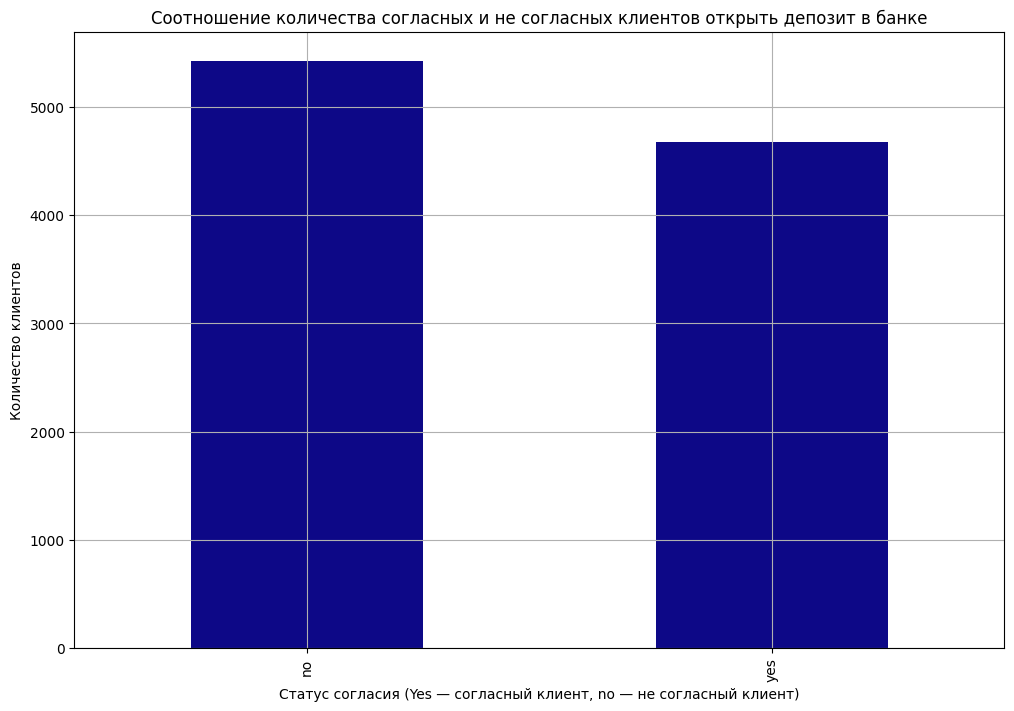

In [15]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат

churn_df = df_cleaned['deposit'].value_counts()
churn_df.plot(
    kind='bar',
    grid=True,
    figsize=(12, 8),
    colormap='plasma'
);
plt.title('Соотношение количества согласных и не согласных клиентов открыть депозит в банке')
plt.xlabel('Статус согласия (Yes — согласный клиент, no — не согласный клиент)')
plt.ylabel('Количество клиентов')

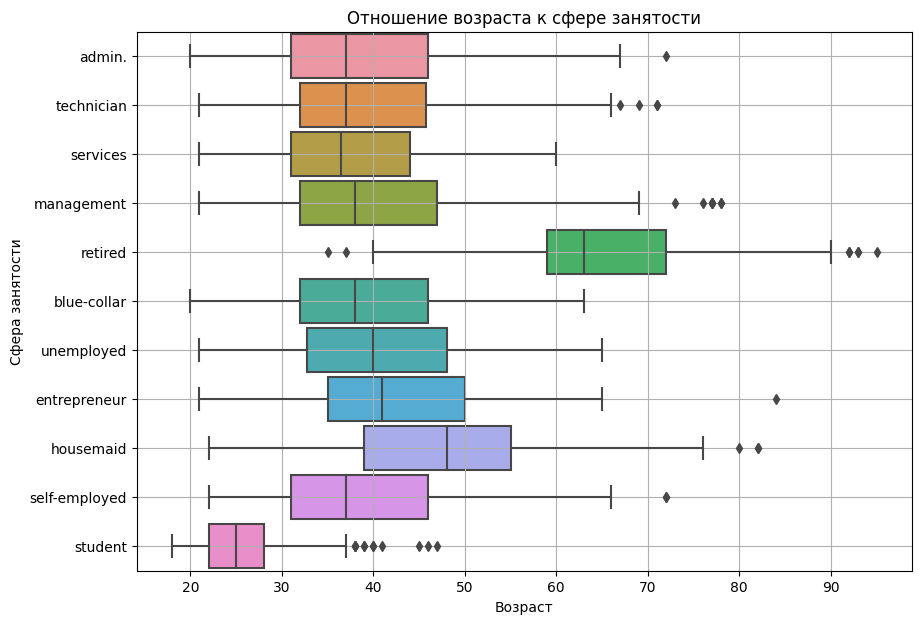

In [16]:
# Построим коробчатую диаграмму для признака age

fig = plt.figure(figsize=(10, 7))
boxplot = sns.boxplot(
   data=df_cleaned,
    x='age',
    y='job',
    orient='h',
    width=0.9
)
boxplot.set_title('Отношение возраста к сфере занятости');
boxplot.set_xlabel('Возраст');
boxplot.set_ylabel('Сфера занятости');
boxplot.grid()

*Коробчатая диаграмма для признака age показывает, что наблюдаются выбросы в группе студентов старше 37 лет и группе пенсионеры младше 40*

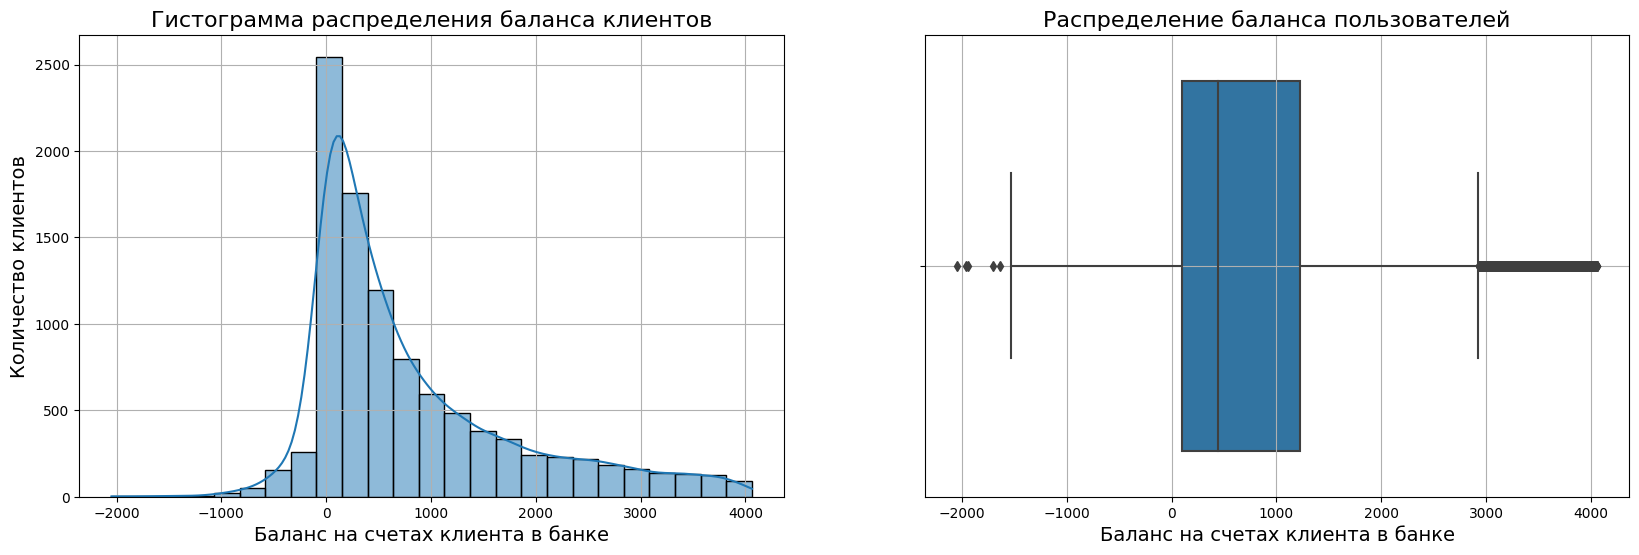

In [17]:
churn_df_2 = df_cleaned
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,6))
histplot = sns.histplot(
    data=churn_df_2,
    x='balance',
    bins=25,
    kde=True,
    ax=axes[0]
);
histplot.set_title('Гистограмма распределения баланса клиентов', fontsize=16);
histplot.set_xlabel('Баланс на счетах клиента в банке', fontsize=14);
histplot.set_ylabel('Количество клиентов', fontsize=14);
histplot.grid()

boxplot = sns.boxplot(
    data=churn_df_2,
    x='balance',
    orient='h',
    ax=axes[1]
)
boxplot.set_title('Распределение баланса пользователей', fontsize=16);
boxplot.set_xlabel('Баланс на счетах клиента в банке', fontsize=14);
boxplot.grid()

*Исходя из графиков можно сделать выводы что большая часть клиентов банка более 1700 человек имеет на счетах в банке около 400 долларов, что является медианным значением. Расброс баланса на счетах в банке составляет прмерно от -2000 до 4000 долларов. Большая часть клиентов банка хранят на счетах от 0 до 1200 долларов*

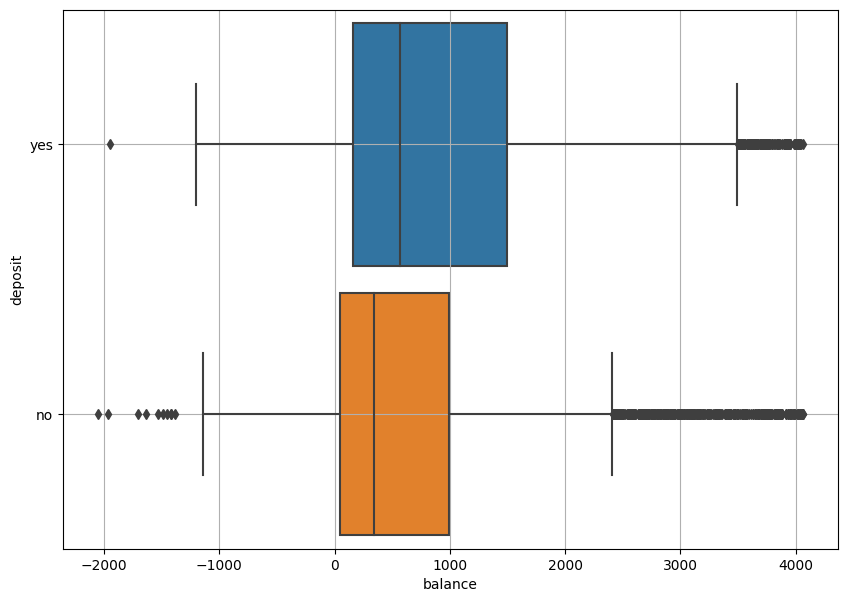

In [18]:
# Распределение баланса клиента в разрезе признака лояльности
churn_data = df_cleaned.copy()

fig = plt.figure(figsize=(10, 7))
boxplot = sns.boxplot(
    data=churn_data,
    y='deposit',
    x='balance',
    orient='h',
    width=0.9
)
boxplot.grid()

*Из графика видно, что границы распределения и межквартильный размах суммы на счетах лояльных клиентов смещены в правую сторону, а значит в среднем лояльные клиенты хранят большие суммы на счетах в банке, чем не лояльные*

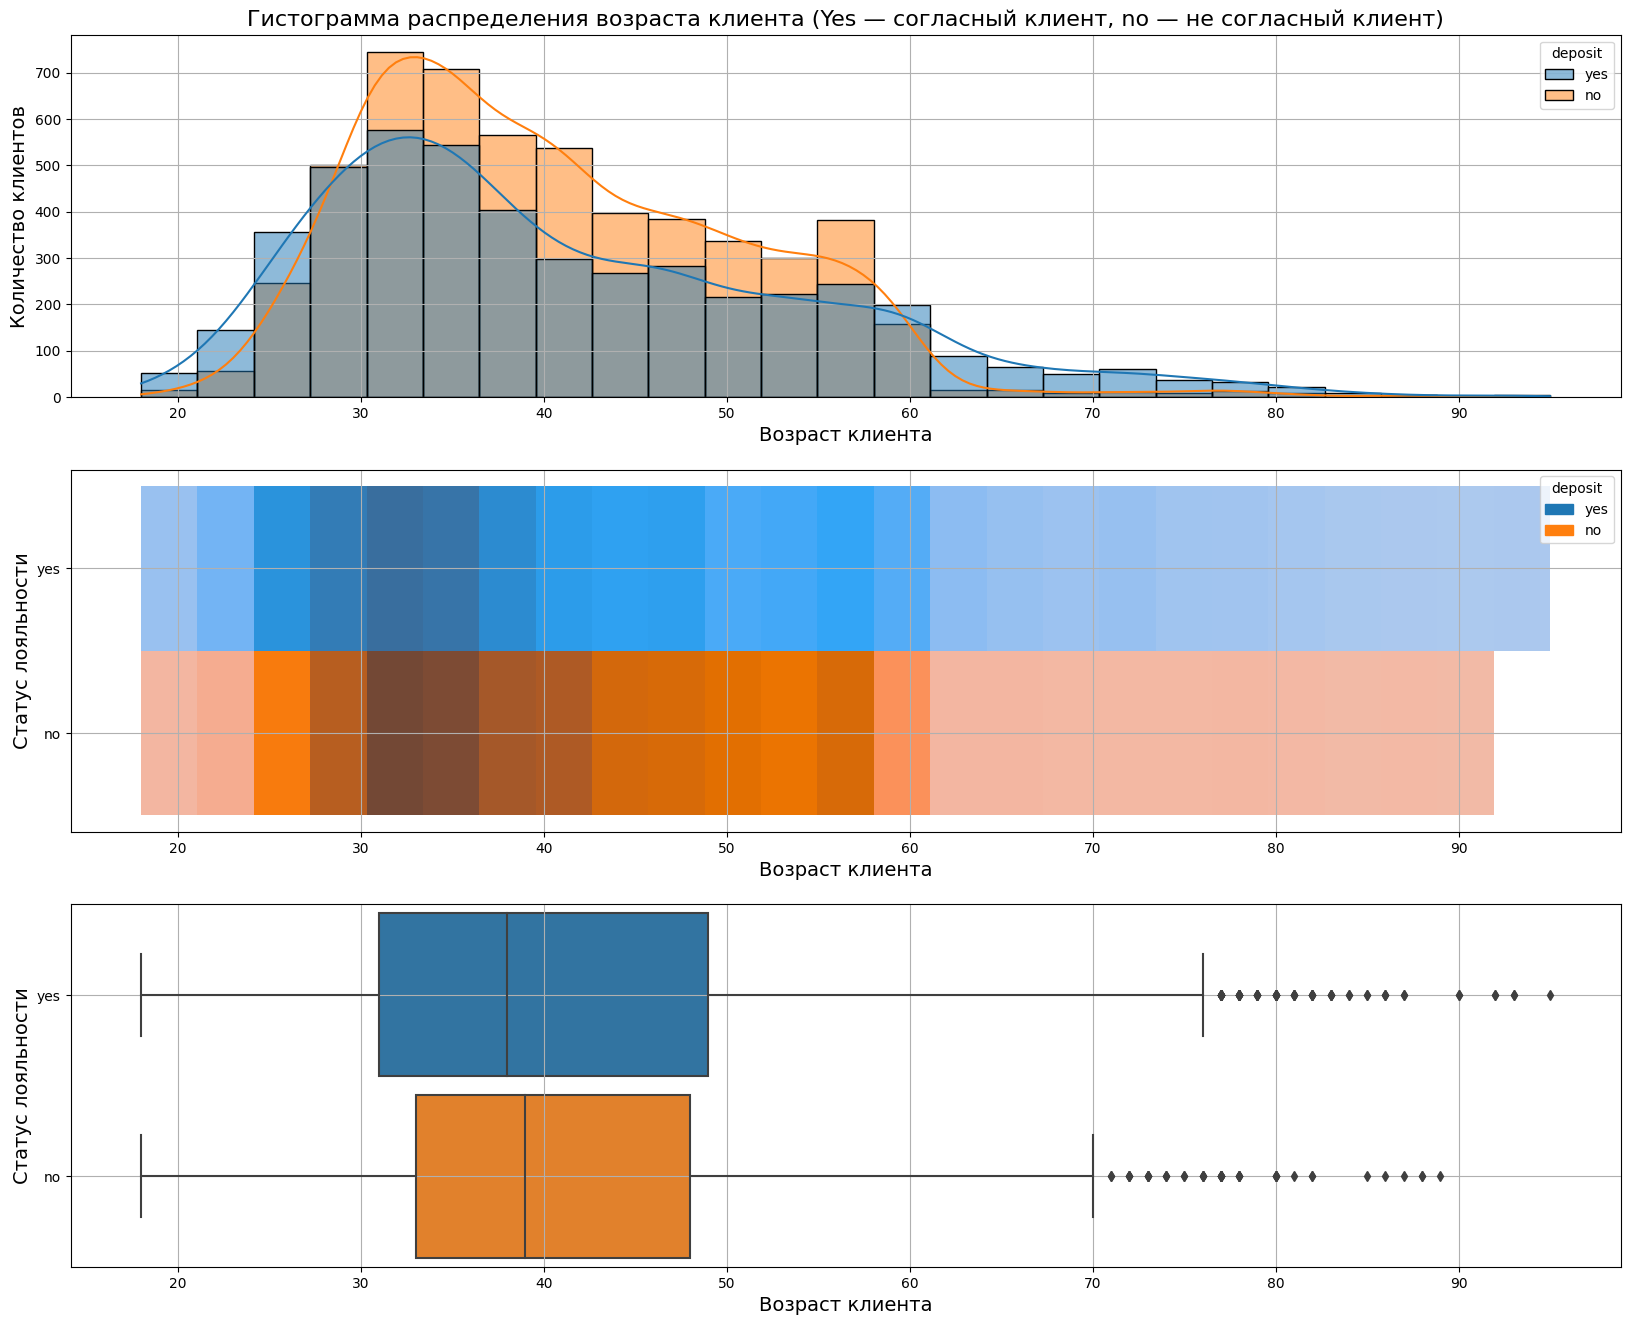

In [19]:
# Распределение возраста в разрезе признака лояльности

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20,16))
histplot = sns.histplot(
    data=churn_data,
    x='age',
    bins=25,
    kde=True,
    hue='deposit',
    ax=axes[0]
);
histplot.set_title('Гистограмма распределения возраста клиента (Yes — согласный клиент, no — не согласный клиент)', fontsize=16);
histplot.set_xlabel('Возраст клиента', fontsize=14);
histplot.set_ylabel('Количество клиентов', fontsize=14);
histplot.grid()
      
histplot = sns.histplot(
    data=churn_data,
    x='age',
    y='deposit',
    bins=25,
    kde=True,
    hue='deposit',
    ax=axes[1]
);
histplot.set_xlabel('Возраст клиента', fontsize=14);
histplot.set_ylabel('Статус лояльности', fontsize=14);
histplot.grid()

boxplot = sns.boxplot(
    data=churn_data,
    y='deposit',
    x='age',
    orient='h',
    ax=axes[2],
    width=0.9
)
boxplot.set_xlabel('Возраст клиента', fontsize=14);
boxplot.set_ylabel('Статус лояльности', fontsize=14);
boxplot.grid()

*Из гистограммы распределения возраста клиентов видно, что средний возраст согласных и не согласных клиентов открыть депозит в банке практически не оказывает влияние*

### Задания 2 и 3

In [20]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат

max_age= df_cleaned['age'].max()
min_duration = df_cleaned['duration'].min()
print(f'Максимальный возраст клиента банка: {max_age}')
print(f'Максимальная продолжительность разговора: {min_duration}')

Максимальный возраст клиента банка: 95
Максимальная продолжительность разговора: 2


### Задания 4 и 5

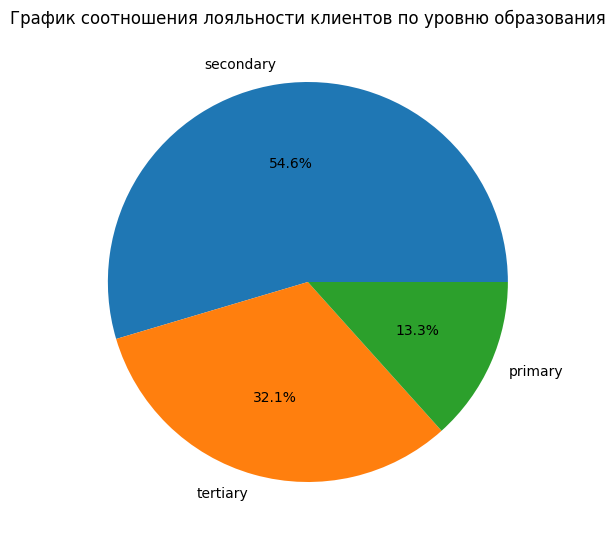

In [21]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#ваш код
#постройте визуализации, иллюстрирующие результаты
# Построим график согласных клиентов в зависимости от образования
churn_data = df_cleaned.copy()

churn_df = churn_data['education'].value_counts()
fig = plt.figure(figsize=(5,5))
axes = fig.add_axes([0,0,1,1])
axes.pie(
    churn_df,
    labels=churn_df.index,
    autopct='%.1f%%'
)
title= axes.set_title('График соотношения лояльности клиентов по уровню образования')

*График показывает, что среди клиентов преобладающее количество более 50% составляет клиеты с образованием secondary*

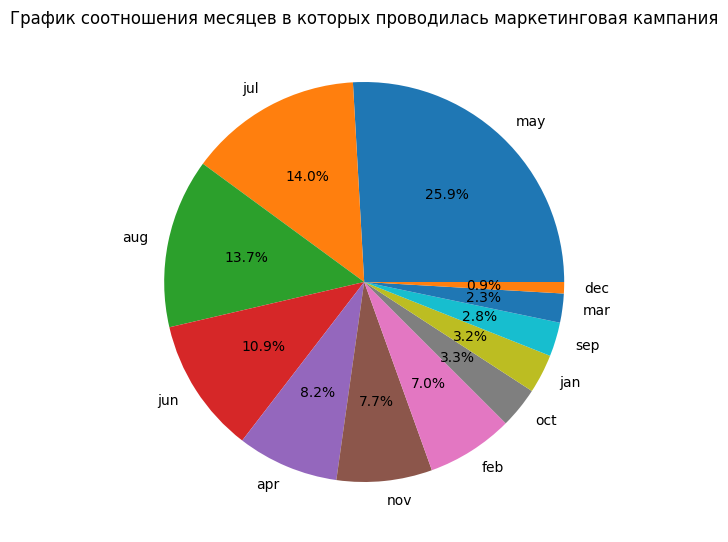

In [22]:
# Построим график месяцев в которых проводилась маркетинговая кампания
churn_data = df_cleaned.copy()

churn_df = churn_data[churn_data['duration'] > 0]['month'].value_counts()
fig = plt.figure(figsize=(5,5))
axes = fig.add_axes([0,0,1,1])
axes.pie(
    churn_df,
    labels=churn_df.index,
    autopct='%.1f%%'
)
title= axes.set_title('График соотношения месяцев в которых проводилась маркетинговая кампания')

*График показывает, что маркетинговая компания проводилась в течении 12ти месяцев, но приемущественно в весенние и летние месяца*

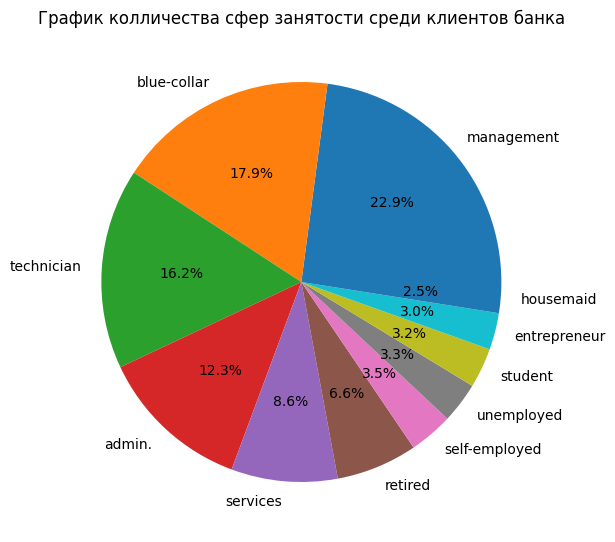

In [23]:
# Построим график колличества сфер занятости среди клиентов банка
churn_data = df_cleaned.copy()

churn_df = churn_data['job'].value_counts()
fig = plt.figure(figsize=(5,5))
axes = fig.add_axes([0,0,1,1])
axes.pie(
    churn_df,
    labels=churn_df.index,
    autopct='%.1f%%'
)
title= axes.set_title('График колличества сфер занятости среди клиентов банка')

In [24]:
print(f'График показывает, что среди клиентов банка наблюдается 11 сфер занятости, приемуществеено в сферах:{churn_df.head(4)}')

График показывает, что среди клиентов банка наблюдается 11 сфер занятости, приемуществеено в сферах:management     2315
blue-collar    1807
technician     1638
admin.         1246
Name: job, dtype: int64


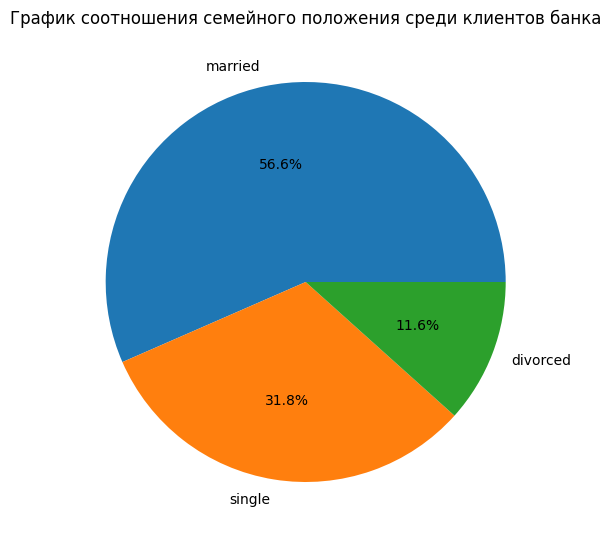

In [25]:
# Построим график соотношения семейного положения среди клиентов банка
churn_data = df_cleaned.copy()

churn_df = churn_data['marital'].value_counts()
fig = plt.figure(figsize=(5,5))
axes = fig.add_axes([0,0,1,1])
axes.pie(
    churn_df,
    labels=churn_df.index,
    autopct='%.1f%%'
)
title= axes.set_title('График соотношения семейного положения среди клиентов банка')

*График показывает, что среди клиентов банка более 50% наблюдаются клиенты состоящие в браке*

### Задание 6

In [26]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.

df_cleaned.groupby(by='poutcome')['deposit'].value_counts()

poutcome  deposit
failure   no          562
          yes         547
other     yes         265
          no          216
success   yes         861
          no           84
unknown   no         4562
          yes        3008
Name: deposit, dtype: int64

### Задание 7

In [27]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
df_grouped = df_cleaned.groupby(by='month')['deposit'].value_counts()
df_grouped

month  deposit
apr    yes         513
       no          317
aug    no          775
       yes         610
dec    yes          84
       no            9
feb    yes         386
       no          323
jan    no          194
       yes         125
jul    no          836
       yes         582
jun    no          606
       yes         498
mar    yes         213
       no           24
may    no         1776
       yes         841
nov    no          456
       yes         324
oct    yes         273
       no           62
sep    yes         232
       no           46
Name: deposit, dtype: int64

In [45]:
month_list = df_cleaned['month'].value_counts().index
new_vac = {}
for i in month_list:
    new_vac[i] = df_grouped.loc[i]['no']/df_grouped.loc[i]['yes']  
    
month_df = pd.DataFrame({'month': new_vac.keys(),'no/yes': new_vac.values()})
f'В месяце {list(month_df.iloc[0])[0]} чаще всего отказывались от предложения открыть депозит'

'В месяце may чаще всего отказывались от предложения открыть депозит'

### Задание 8

In [46]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения

df_age = df_cleaned.copy()

def function_age(x):
    if x <30:
        return '<30'
    elif 30<= x < 40:
        return '30-40'
    elif 40<= x < 50:
        return '40-50'
    elif 50<= x < 60:
        return '50-60'
    else: 
        return '60+'

df_age['age_grouped'] = df_age['age'].apply(function_age)

df_age.groupby(by='age_grouped')['deposit'].value_counts()

age_grouped  deposit
30-40        no         2245
             yes        1716
40-50        no         1444
             yes         938
50-60        no          984
             yes         670
60+          yes         496
             no          157
<30          yes         861
             no          594
Name: deposit, dtype: int64

### Задания 9 и 10

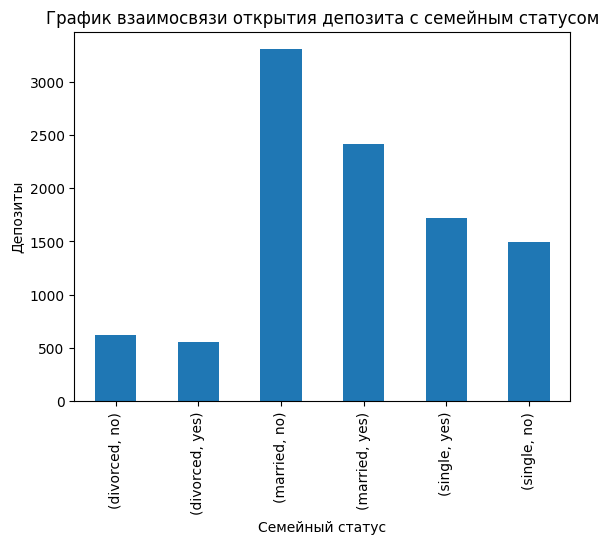

In [48]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
df_grouped = df_age.copy()
#df_grouped
df_grouped = df_grouped.groupby(['marital'])['deposit'].value_counts().plot(kind='bar', title = 'График взаимосвязи открытия депозита с семейным статусом', xlabel = 'Семейный статус', ylabel = 'Депозиты')

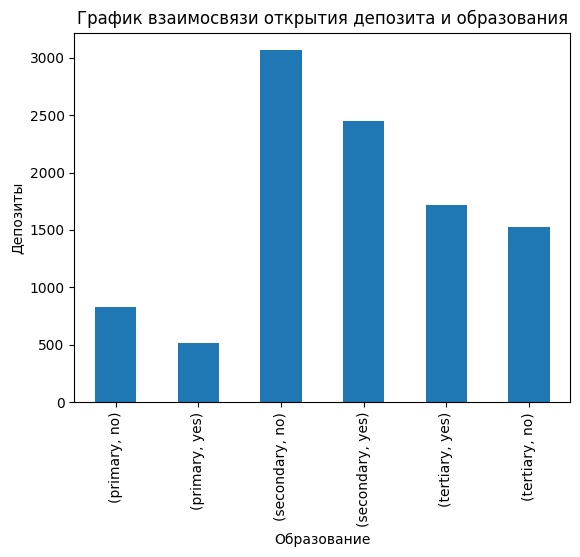

In [49]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
df_grouped = df_age.copy()

df_grouped = df_grouped.groupby(['education'])['deposit'].value_counts().plot(kind='bar', title = 'График взаимосвязи открытия депозита и образования', xlabel = 'Образование', ylabel = 'Депозиты')

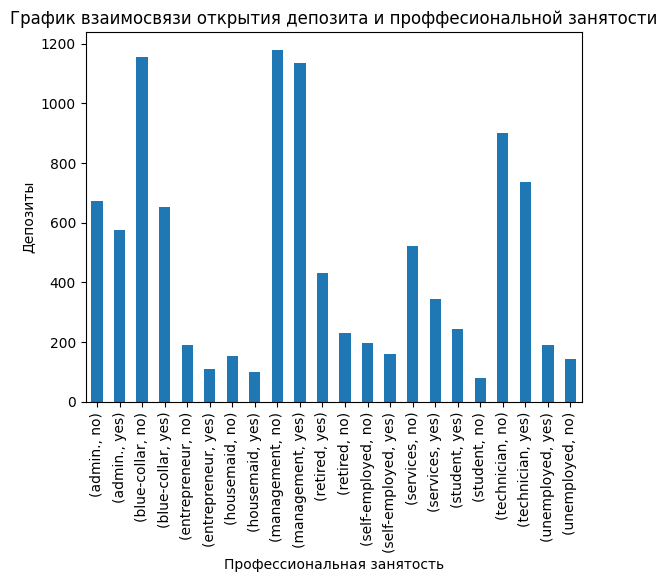

In [50]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
df_grouped = df_age.copy()

df_grouped = df_grouped.groupby(['job'])['deposit'].value_counts().plot(kind='bar', title = 'График взаимосвязи открытия депозита и проффесиональной занятости', xlabel = 'Профессиональная занятость', ylabel = 'Депозиты')

### Задание 11

In [51]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
churn_data = df_age.copy()
fig = plt.figure(figsize=(20,5))
mask_deposit_yes = churn_data['deposit'] == 'yes'
mask_deposit_no = churn_data['deposit'] == 'no'

pivot_yes = churn_data[mask_deposit_yes].pivot_table(
    columns="marital",
    values="deposit", 
    index="education",
    aggfunc='count'
)
pivot_no = churn_data[mask_deposit_no].pivot_table(
    columns="marital",
    values="deposit", 
    index="education",
    aggfunc='count'
)

<Figure size 2000x500 with 0 Axes>

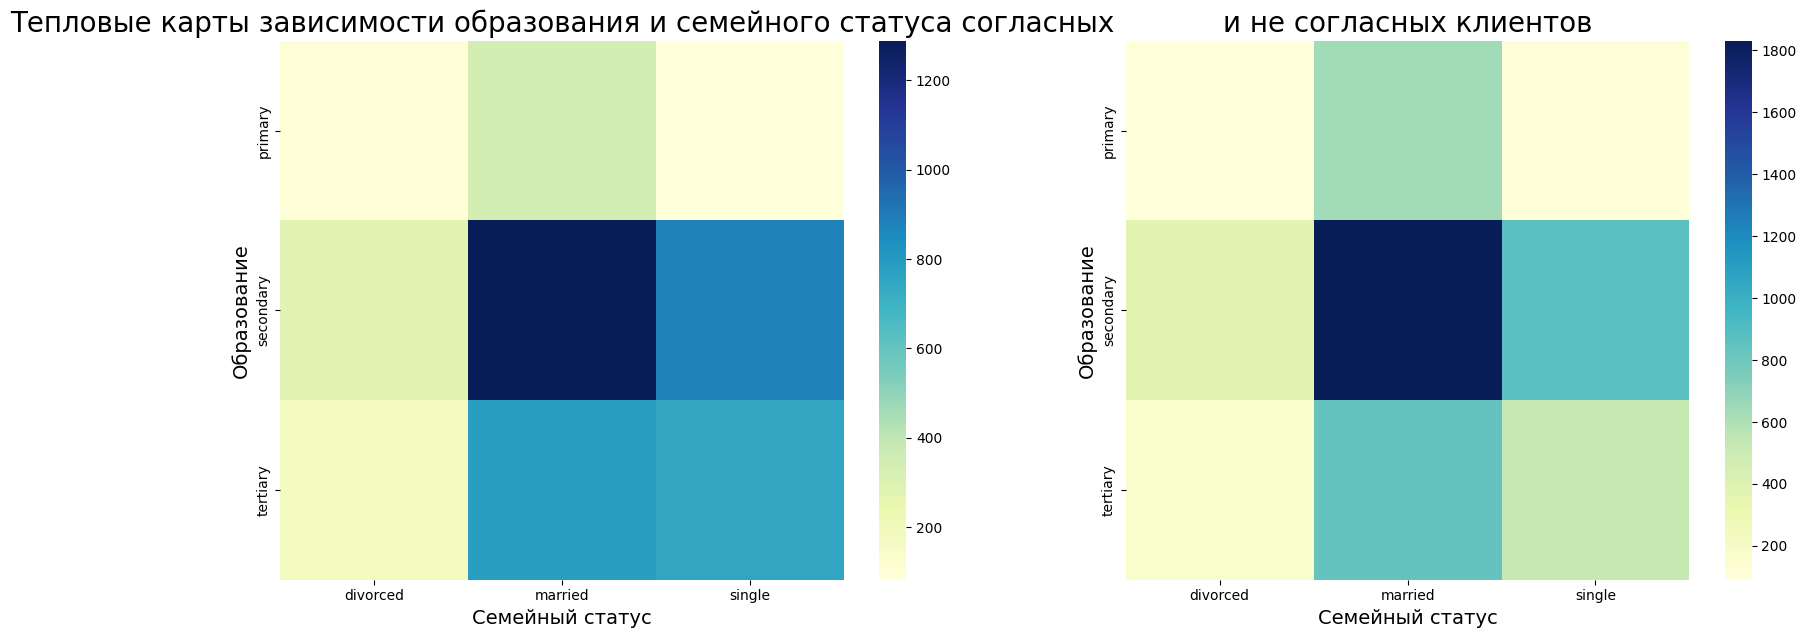

In [52]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))

heatmap1 = sns.heatmap(data=pivot_yes, cmap='YlGnBu', ax = axes[0])
heatmap1.set_title('Тепловые карты зависимости образования и семейного статуса согласных', fontsize=20);
heatmap1.set_xlabel('Семейный статус', fontsize=14);
heatmap1.set_ylabel('Образование', fontsize=14);

heatmap2 = sns.heatmap(data=pivot_no, cmap='YlGnBu', ax = axes[1])
heatmap2.set_title('и не согласных клиентов', fontsize=20);
heatmap2.set_xlabel('Семейный статус', fontsize=14);
heatmap2.set_ylabel('Образование', fontsize=14);

*Тепловые карты зависимости показывают, что наиболее активная группа с семейным статусом married и образованием secondary*

## Часть 3: преобразование данных

### Задание 1

In [54]:
from sklearn.preprocessing import LabelEncoder

df_encoded= df_age.copy()

le = preprocessing.LabelEncoder()
df_encoded['education'] = le.fit_transform(df_encoded.education)

'Сумма получившихся значений для признака education: {}'.format(df_encoded['education'].sum())

'Сумма получившихся значений для признака education: 11995'

### Задания 2 и 3

In [55]:
# преобразуйте бинарные переменные в представление из нулей и единиц

df_encoded['age_grouped'] = le.fit_transform(df_encoded['age_grouped'])
df_encoded['deposit']= df_encoded['deposit'].apply(lambda x: 1 if x == 'yes' else 0)

def function_yes_no(x):
    if x == 'yes':
        return 1
    else:
        return 0

df_encoded['default']= df_encoded['default'].apply(function_yes_no)
df_encoded['housing']= df_encoded['housing'].apply(function_yes_no)
df_encoded['loan']= df_encoded['loan'].apply(function_yes_no)

print('Стандартное отклонение по преобразованной в корректный вид целевой переменной deposit: {}'.format(round(df_encoded['deposit'].std(), 3)))
print('Среднее арифметическое для каждой из получившихся переменных: {}'.format(round((df_encoded['default'].mean()+ df_encoded['housing'].mean()+ df_encoded['loan'].mean()), 3)))

Стандартное отклонение по преобразованной в корректный вид целевой переменной deposit: 0.499
Среднее арифметическое для каждой из получившихся переменных: 0.635


### Задание 4

In [56]:
# создайте дамми-переменные
df_dummies = df_encoded.copy()

df_dummies = pd.get_dummies(df_dummies, columns=['job', 'marital', 'contact', 'month', 'poutcome'], drop_first=False)

In [59]:
mask_add_columns = ['job', 'marital', 'contact', 'month', 'poutcome']

#Перекодируем признаки 'job', 'marital', 'contact', 'month', 'poutcome' с помощью LabelEncoder
le = preprocessing.LabelEncoder()

df_encoded_le = df_encoded[mask_add_columns].copy()

df_encoded_le['job'] = le.fit_transform(df_encoded_le['job'])
df_encoded_le['marital'] = le.fit_transform(df_encoded_le['marital'])
df_encoded_le['contact'] = le.fit_transform(df_encoded_le['contact'])
df_encoded_le['month'] = le.fit_transform(df_encoded_le['month'])
df_encoded_le['poutcome'] = le.fit_transform(df_encoded_le['poutcome'])

#Объединим таблицы
df_dummies_concat = pd.concat(
[df_dummies, df_encoded_le],
ignore_index=False,
axis=1
)

'Всего признаков в датасете: {}'.format(df_dummies_concat.shape[1] - 1)

'Всего признаков в датасете: 50'

### Задания 5 и 6

In [60]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
#df_dummies['deposit']= df_dummies['deposit'].apply(function_yes_no)
fig = plt.figure(figsize=(100, 100))

heatmap = sns.heatmap(round(df_dummies_concat.corr(method='spearman'), 2), annot = True, cmap= 'coolwarm')
heatmap.set_title('Матрица корреляций', fontsize=14);

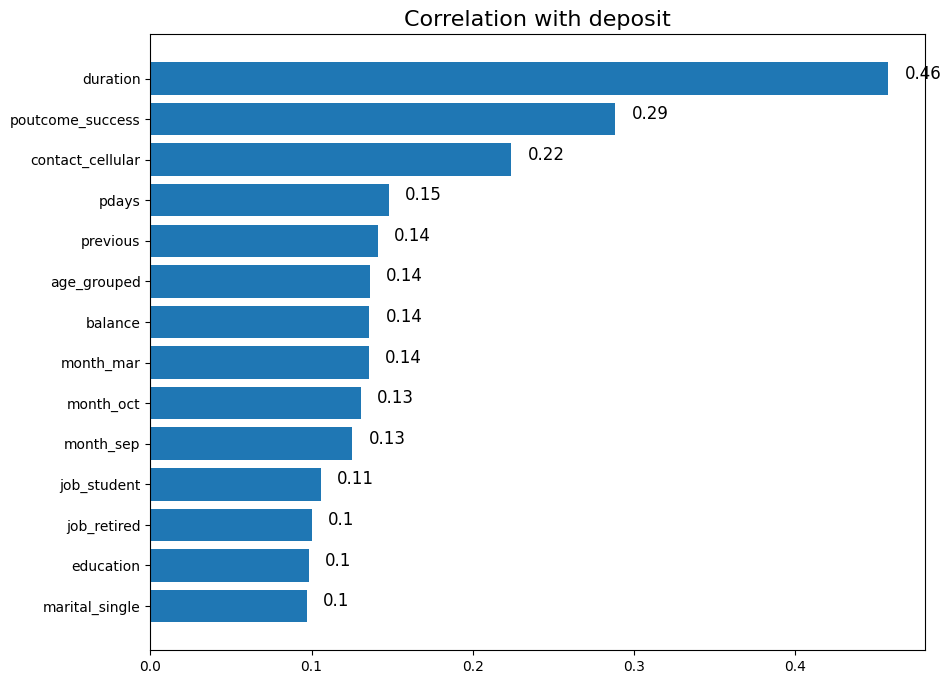

In [61]:
corr_values = df_dummies_concat.corr()["deposit"].apply(lambda x: x).sort_values()[-15:-1]

fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(corr_values.index, corr_values.values)

for i, v in enumerate(corr_values.values):
    ax.text(v + 0.01, i, str(round(v, 2)), fontsize=12)

ax.set_title("Correlation with deposit", fontsize=16)
plt.show()

### Задания 7 и 8

In [62]:
X = df_dummies_concat.drop(['deposit'], axis=1)
y = df_dummies_concat['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [63]:
# рассчитайте необходимые показатели
print('Размер тестовой выборки: {}'.format(X_test.shape))
print('Среднее значение целевой переменной на тестовой выборке: {}'.format(round(y_test.mean(), 2)))

Размер тестовой выборки: (3335, 50)
Среднее значение целевой переменной на тестовой выборке: 0.46


### Задание 9

In [65]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(f_classif, k=15)
selector.fit(X_train, y_train)

SelectKBest_columns = selector.get_feature_names_out()
print(SelectKBest_columns)

['housing' 'duration' 'campaign' 'pdays' 'previous' 'age_grouped'
 'contact_cellular' 'contact_unknown' 'month_mar' 'month_may' 'month_oct'
 'month_sep' 'poutcome_success' 'poutcome_unknown' 'contact']


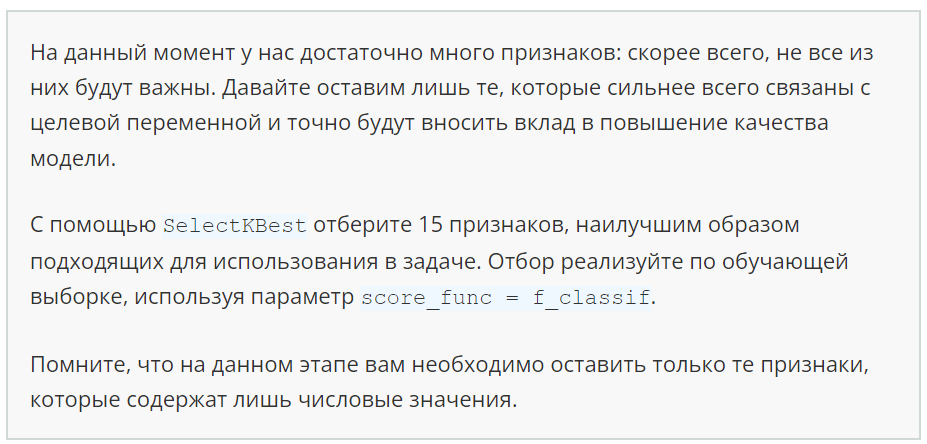

### Задание 10

In [69]:
# нормализуйте данные с помощью minmaxsxaler
mm_scaler = preprocessing.MinMaxScaler()

X_train_mm_scaled = mm_scaler.fit_transform(X_train)
X_test_mm_scaled = mm_scaler.fit_transform(X_test)

# Преобразуем промежуточный датасет в полноценный датафрейм
X_train_mm_scaled = pd.DataFrame(X_train_mm_scaled, columns=X_train.columns)
X_test_mm_scaled = pd.DataFrame(X_test_mm_scaled, columns=X_train.columns)

X_train_mm_scaled = X_train_mm_scaled[SelectKBest_columns]
X_test_mm_scaled = X_test_mm_scaled[SelectKBest_columns]

print('Среднее арифметическое для первого предиктора: {}'.format(round(X_train_mm_scaled.mean()[0], 2)))

Среднее арифметическое для первого предиктора: 0.48


# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [70]:
# обучите логистическую регрессию и рассчитайте метрики качества
from sklearn import linear_model
from sklearn import metrics

#Создаём объект класса LogisticRegression
log_reg = linear_model.LogisticRegression(solver='sag', random_state=42, max_iter=1000)
#Обучаем модель, минизируя logloss
log_reg.fit(X_train_mm_scaled, y_train)

#Делаем предсказание для тренировочной выборки
y_train_pred = log_reg.predict(X_train_mm_scaled)

#Делаем предсказание для тестовой выборки
y_test_pred = log_reg.predict(X_test_mm_scaled)

# Рассчитываем метрику
print(metrics.classification_report(y_train, y_train_pred))
print(metrics.classification_report(y_test, y_test_pred))
print('Test accuracy: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

              precision    recall  f1-score   support

           0       0.80      0.88      0.84      3634
           1       0.84      0.75      0.79      3136

    accuracy                           0.82      6770
   macro avg       0.82      0.81      0.81      6770
weighted avg       0.82      0.82      0.82      6770

              precision    recall  f1-score   support

           0       0.84      0.82      0.83      1790
           1       0.79      0.82      0.80      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335

Test accuracy: 0.82


### Задания 2,3,4

In [71]:
# обучите решающие деревья, настройте максимальную глубину
from sklearn import tree

#Создаём объект класса DecisionTreeClassifier
dt_clf = tree.DecisionTreeClassifier(
    criterion='entropy',
    #max_depth=6,
    random_state=42
)

#Обучаем дерево решений по алгоритму CART
dt_clf.fit(X_train_mm_scaled, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=42)

In [72]:
#Делаем предсказание для тренировочной выборки
y_train_pred = dt_clf.predict(X_train_mm_scaled)

#Делаем предсказание для тестовой выборки
y_test_pred = dt_clf.predict(X_test_mm_scaled)

# Рассчитываем метрику
print(metrics.classification_report(y_train, y_train_pred))
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3634
           1       1.00      0.98      0.99      3136

    accuracy                           0.99      6770
   macro avg       0.99      0.99      0.99      6770
weighted avg       0.99      0.99      0.99      6770

              precision    recall  f1-score   support

           0       0.79      0.72      0.75      1790
           1       0.70      0.78      0.74      1545

    accuracy                           0.75      3335
   macro avg       0.75      0.75      0.75      3335
weighted avg       0.75      0.75      0.75      3335



*Наблюдаем переобучение модели*

In [73]:
#Создаём объект класса DecisionTreeClassifier
dt_clf = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_depth=7,#|max_depth=6
    random_state=42
)

#Обучаем дерево решений по алгоритму CART
dt_clf.fit(X_train_mm_scaled, y_train)

#Делаем предсказание для тренировочной выборки
y_train_pred = dt_clf.predict(X_train_mm_scaled)

#Делаем предсказание для тестовой выборки
y_test_pred = dt_clf.predict(X_test_mm_scaled)

# Рассчитываем метрику
print('Test accuracy: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

Test accuracy: 0.81


### Задание 5

In [74]:
# подберите оптимальные параметры с помощью gridsearch
from sklearn.model_selection import GridSearchCV

param_grid = {'min_samples_split': [2, 5, 7, 10] , # тип регуляризации
              'max_depth': [3,5,7], # алгоритм оптимизации
             }
grid_search = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(criterion='entropy',random_state=42), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)
%time grid_search.fit(X_train_mm_scaled, y_train) 
print("Наилучшая модель:\n{}".format(grid_search.best_estimator_))
y_test_pred = grid_search.predict(X_test_mm_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

CPU times: total: 359 ms
Wall time: 11.1 s
Наилучшая модель:
DecisionTreeClassifier(criterion='entropy', max_depth=7, min_samples_split=10,
                       random_state=42)
f1_score на тестовом наборе: 0.80


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [75]:
# обучите на ваших данных случайный лес
from sklearn import ensemble

rf_clf = ensemble.RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    min_samples_leaf = 5,
    max_depth=10,
    random_state=42
)
#Обучаем модель
rf_clf.fit(X_train_mm_scaled, y_train)

#Делаем предсказание для тренировочной выборки
y_train_pred = rf_clf.predict(X_train_mm_scaled)

#Делаем предсказание для тестовой выборки
y_test_pred = rf_clf.predict(X_test_mm_scaled)

# Рассчитываем метрику
print(metrics.classification_report(y_test, y_test_pred))
print('Test accuracy: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))
print('Test recall: {:.2f}'.format(metrics.recall_score(y_test, y_test_pred)))

              precision    recall  f1-score   support

           0       0.88      0.75      0.81      1790
           1       0.76      0.88      0.82      1545

    accuracy                           0.81      3335
   macro avg       0.82      0.82      0.81      3335
weighted avg       0.82      0.81      0.81      3335

Test accuracy: 0.81
Test recall: 0.88


### Задания 2 и 3

In [76]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
from sklearn.ensemble import GradientBoostingClassifier

# Создаем объект класса градиентный бустинг
gb = GradientBoostingClassifier(
    learning_rate = 0.05,
    n_estimators=300,    #количество деревьев в ансамбле
    min_samples_leaf = 5,
    max_depth=5, #максимальная глубина дерева
    random_state=42 #датчик генератора случайных чисел
)

# Обучаем модель
gb.fit(X_train_mm_scaled, y_train)

#Делаем предсказание для тренировочной выборки
y_train_pred = gb.predict(X_train_mm_scaled)

#Делаем предсказание для тестовой выборки
y_test_pred = gb.predict(X_test_mm_scaled)

# Рассчитываем метрику
print('Test F1: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Test F1: 0.81


### Задание 4

In [77]:
# объедините уже известные вам алгоритмы с помощью стекинга 
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import tree
from sklearn import linear_model

estimators = [
    ('dtc', dt_clf),#tree.DecisionTreeClassifier
    ('lr', log_reg),#linear_model.LogisticRegression
    ('gb',  gb)#GradientBoostingClassifier
]

# Создаем объект класса стекинг
reg = ensemble.StackingClassifier(
    estimators=estimators, #базовые модели в стекинге
    final_estimator=log_reg,
    n_jobs=-1
)
# Обучаем модель
reg.fit(X_train_mm_scaled, y_train)

#Делаем предсказание для тренировочной выборки
y_train_pred = reg.predict(X_train_mm_scaled)

#Делаем предсказание для тестовой выборки
y_test_pred = reg.predict(X_test_mm_scaled)

# Рассчитываем метрику
print('Test precision: {:.2f}'.format(metrics.precision_score(y_test, y_test_pred)))

Test precision: 0.77


### Задание 5

In [78]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
#C помощью метода рекурсивного исключения признаков (RFE) выделим три наиболее значимых признака
from sklearn.feature_selection import RFE

estimator = GradientBoostingClassifier()

#X_train_RFE = X_train_mm_scaled.drop(columns='contact', axis=1)
selector = RFE(estimator, n_features_to_select=3, step=1)
selector = selector.fit(X_train_mm_scaled, y_train)
 
selector.get_feature_names_out()

array(['duration', 'poutcome_success', 'contact'], dtype=object)

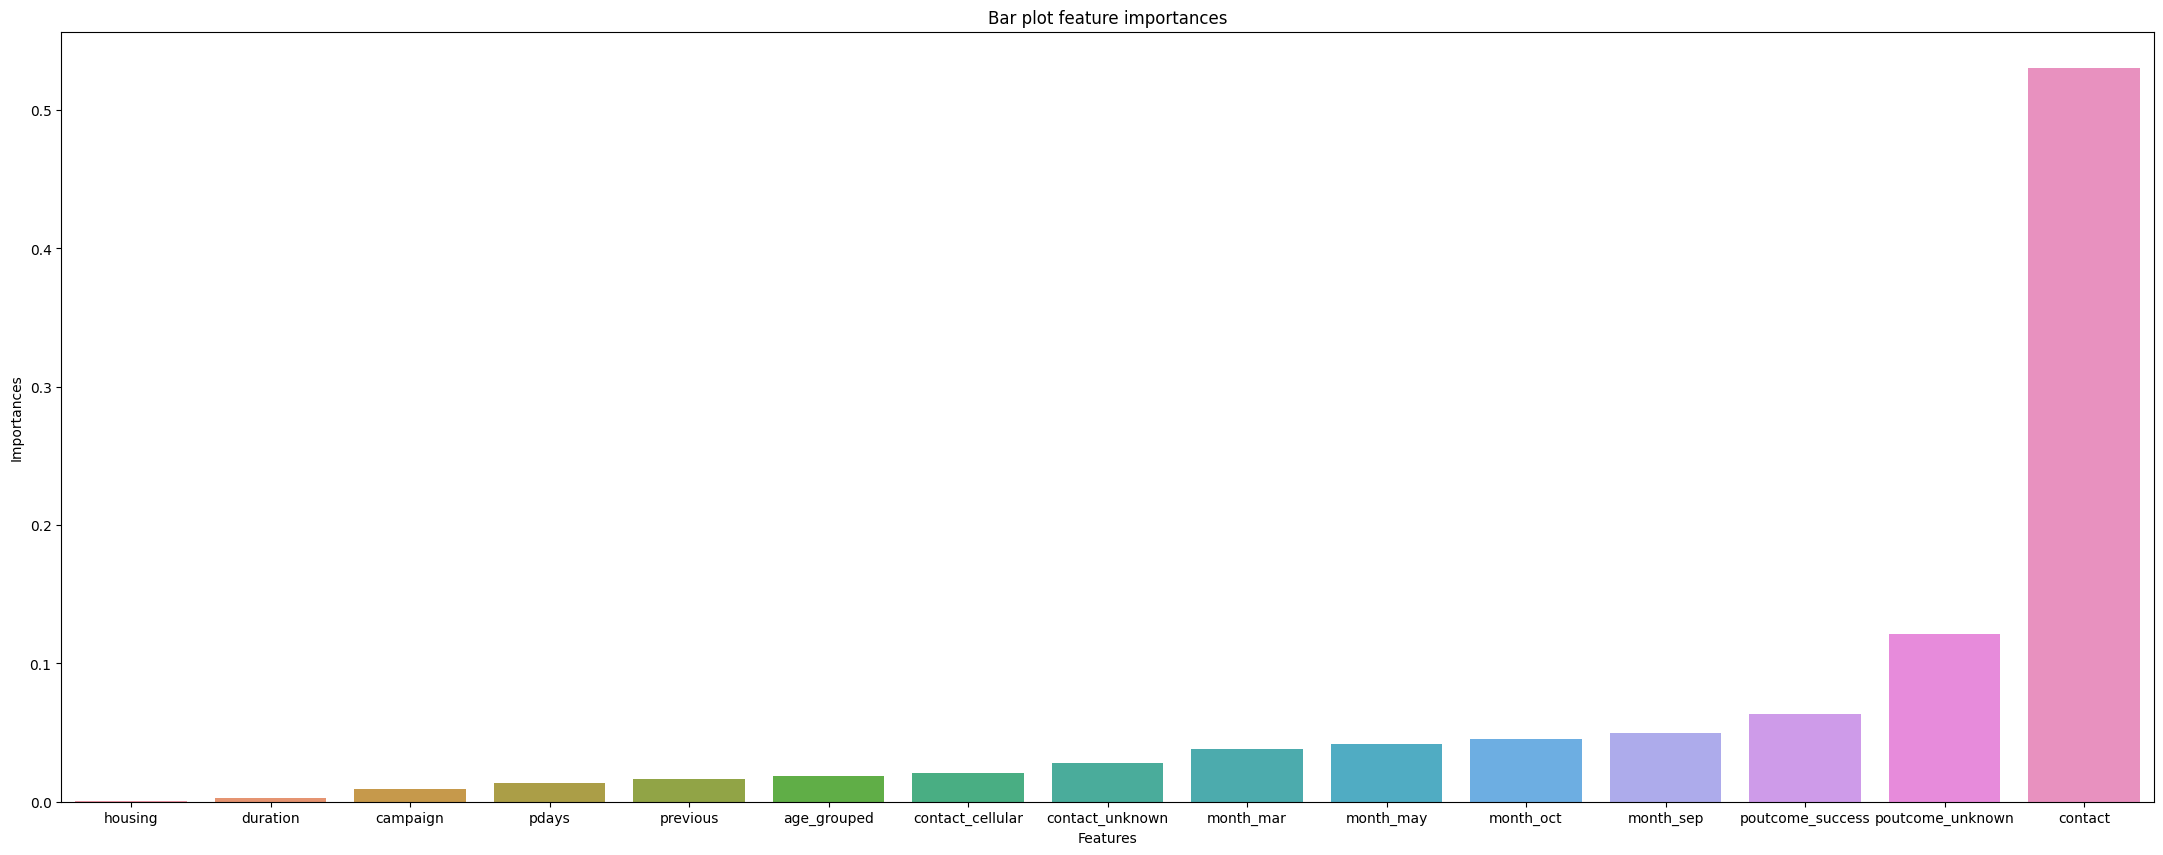

In [79]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
fig, ax = plt.subplots(figsize=(27, 10)) #фигура + координатная плоскость
#columns = reg.estimators_[0].feature_names_in_
#feature_importances = reg.estimators_[0].feature_importances_
feature = X_train_mm_scaled.columns #признаки
feature_importances = reg.estimators_[2].feature_importances_ #важность признаков
#Строим столбчатую диаграмму
sns.barplot(x=feature, y=sorted(feature_importances), ax=ax);
#Добавляем подпись графику, осям абцисс и ординат
ax.set_title('Bar plot feature importances')
ax.set_xlabel('Features')
ax.set_ylabel('Importances');

### Задания 6,7,8

In [80]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna
import optuna

def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)
  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  # обучаем модель
  model.fit(X_train_mm_scaled, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train_mm_scaled))

  return score

#%%time
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2024-08-12 19:57:49,313] A new study created in memory with name: RandomForestClassifier
[I 2024-08-12 19:57:50,569] Trial 0 finished with value: 0.8342279760025261 and parameters: {'n_estimators': 171, 'max_depth': 10, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.8342279760025261.
[I 2024-08-12 19:57:52,096] Trial 1 finished with value: 0.857187696170747 and parameters: {'n_estimators': 186, 'max_depth': 13, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.857187696170747.
[I 2024-08-12 19:57:52,959] Trial 2 finished with value: 0.8378335701879047 and parameters: {'n_estimators': 122, 'max_depth': 19, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.857187696170747.
[I 2024-08-12 19:57:54,137] Trial 3 finished with value: 0.8470809203318203 and parameters: {'n_estimators': 157, 'max_depth': 16, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.857187696170747.
[I 2024-08-12 19:57:55,465] Trial 4 finished with value: 0.845732184808144 and parameters: {'n_esti

In [81]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 174, 'max_depth': 28, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.91


In [82]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=42, )
model.fit(X_train_mm_scaled, y_train)
y_train_pred = model.predict(X_train_mm_scaled)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test_mm_scaled, y_test)))
y_test_pred = model.predict(X_test_mm_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.82
f1_score на тестовом наборе: 0.82
